COEN 240 Final Project
Team 6
Author: Haoning Xia, Tianyi Liu

In [1]:
#import data
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

dataset = fetch_20newsgroups(subset='all',shuffle=False,remove=('headers','footers','quotes'))
corpus = dataset.data     #total 18846 entries
labels = dataset.target  #total 18846 entries


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)


In [2]:
#Preprocessing & Word Frequency
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora
from gensim.parsing.preprocessing import *
from pprint import pprint

CUSTOM_FILTERS = [lambda x:x.lower(),strip_tags,strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]
docs = [preprocess_string(doc,CUSTOM_FILTERS) for doc in corpus]
freqs  = defaultdict(int)
for doc in docs:
    for word in doc:
        freqs[word] +=1
sorted_freqs = sorted(freqs.items(), key=lambda item:item[1], reverse=True)

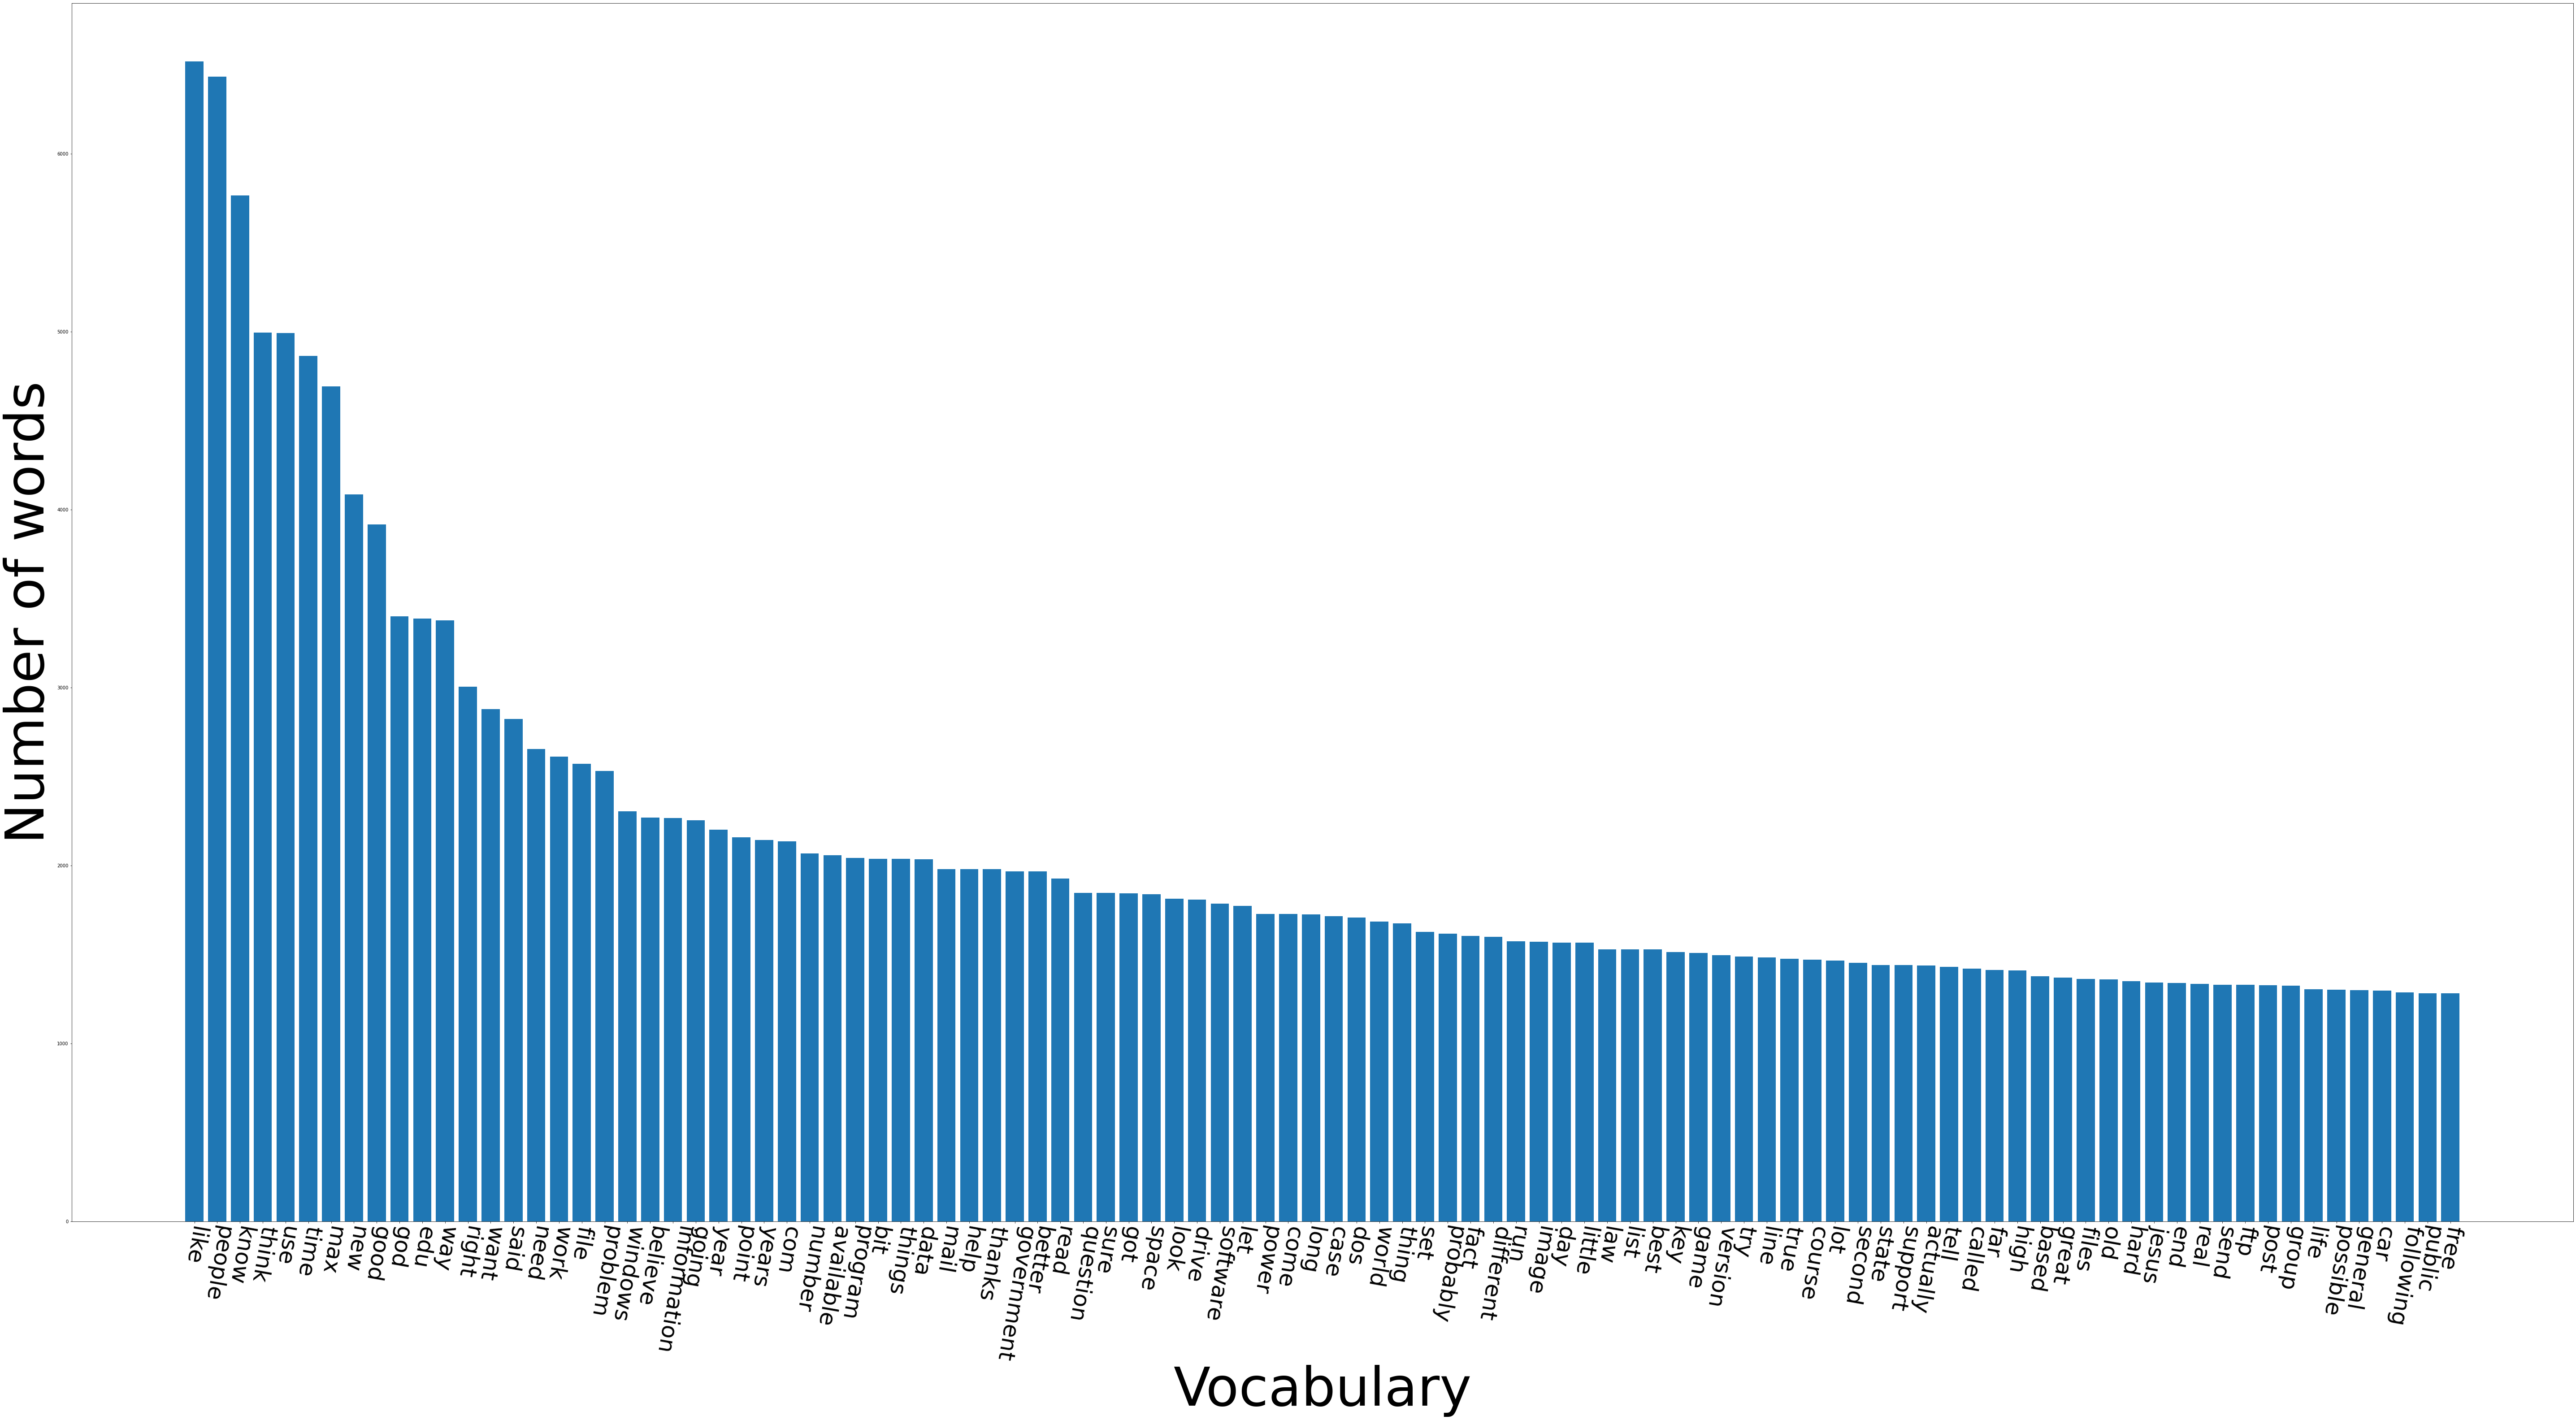

In [5]:
#Vitilize statistical information
fig,ax = plt.subplots(1,figsize=(100,50))
ax.bar([word[0] for word in sorted_freqs[:100]], [word[1] for word in sorted_freqs[:100]])
ax.set_ylabel('Number of words', fontsize=120)
ax.set_xlabel("Vocabulary", fontsize=120)
ax.tick_params(axis='x', rotation=260, labelsize=50)
plt.show()

In [6]:
#Save Vocab_v1 & Vocab_v2
#Learn Bag-of-words (BoW) and TF-IDF model for all the documents.
from gensim.models import TfidfModel
from gensim.models import LdaModel
from copy import deepcopy


dictionary = corpora.Dictionary(docs) #vocab_v1  

dict2 = deepcopy(dictionary)
dict2.filter_extremes(no_below=5, no_above=0.5, keep_n=2000) #vocab_v2

dictionary.compactify()
BoW_corpus = [dictionary.doc2bow(doc) for doc in docs]   
vocab_v1 = [[w for w in doc if w in dictionary.token2id] for doc in docs]
vocab_v2 = [[w for w in doc if w in dict2.token2id] for doc in docs]
print(BoW_corpus[0])
print(vocab_v2[0])

tfidf = TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]  

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]
['run', 'higher', 'year', 'won', 'good', 'think']


In [38]:
#Visualization LDA model Method 1 (pyLDA) for 20 topics
import warnings
import pyLDAvis.gensim as gensimvis
import pyLDAvis
warnings.filterwarnings("ignore",category=DeprecationWarning)

lda = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=20)

#topic distribution for each document.
td_data = lda[BoW_corpus]
print(np.array(td_data[:]))

vis_data = gensimvis.prepare(lda, BoW_corpus, dictionary)
pyLDAvis.display(vis_data)

<ipython-input-38-6bb6eb6774a4>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(td_data[:]))


[list([(0, 0.41558215), (17, 0.5335004)])
 list([(0, 0.036314618), (3, 0.017041791), (5, 0.09366619), (12, 0.43238255), (13, 0.26941466), (17, 0.14301792)])
 list([(4, 0.05991364), (6, 0.024679784), (8, 0.18567364), (9, 0.15653001), (11, 0.25884688), (12, 0.08147559), (17, 0.010131731), (19, 0.1809321)])
 ... list([(12, 0.43002307), (13, 0.5199646)])
 list([(0, 0.06919463), (2, 0.080940835), (3, 0.031055357), (6, 0.010434714), (8, 0.13729693), (9, 0.10094631), (12, 0.48397052), (14, 0.08059834)])
 list([(13, 0.3474044), (17, 0.58828765)])]


In [12]:
#Visualization LDA model Method 1 for 6 topics
warnings.filterwarnings("ignore",category=DeprecationWarning)

lda = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=6)

vis_data = gensimvis.prepare(lda, BoW_corpus, dictionary)
pyLDAvis.display(vis_data)

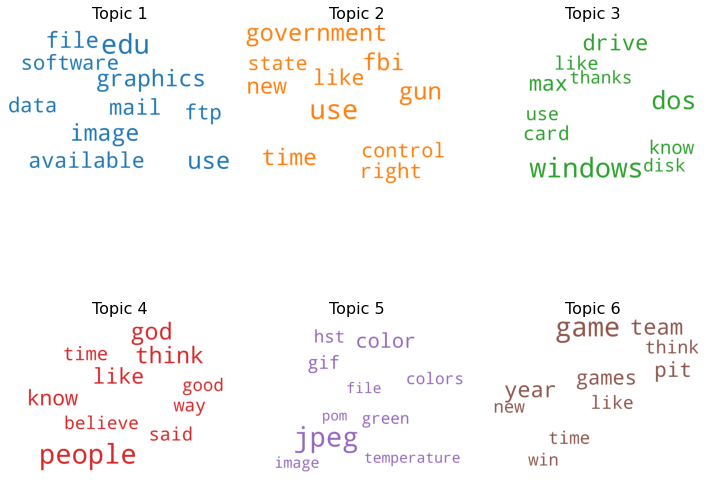

In [13]:
#Visualization LDA model Method 2(Top 10 Keywords)
# The following code is based on https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [15]:
#Train Word2Vec models upon vocab_v1
from gensim.models import Word2Vec

w2v_model = Word2Vec(vocab_v1,
                     min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers = 8)

w2v_model.wv.most_similar(positive=["president"])

[('officials', 0.9828738570213318),
 ('justice', 0.9823564291000366),
 ('today', 0.9787185192108154),
 ('clinton', 0.9775614142417908),
 ('meeting', 0.9759314060211182),
 ('members', 0.9751287698745728),
 ('attorney', 0.9744553565979004),
 ('myers', 0.9737180471420288),
 ('fbi', 0.9725948572158813),
 ('society', 0.9724029302597046)]

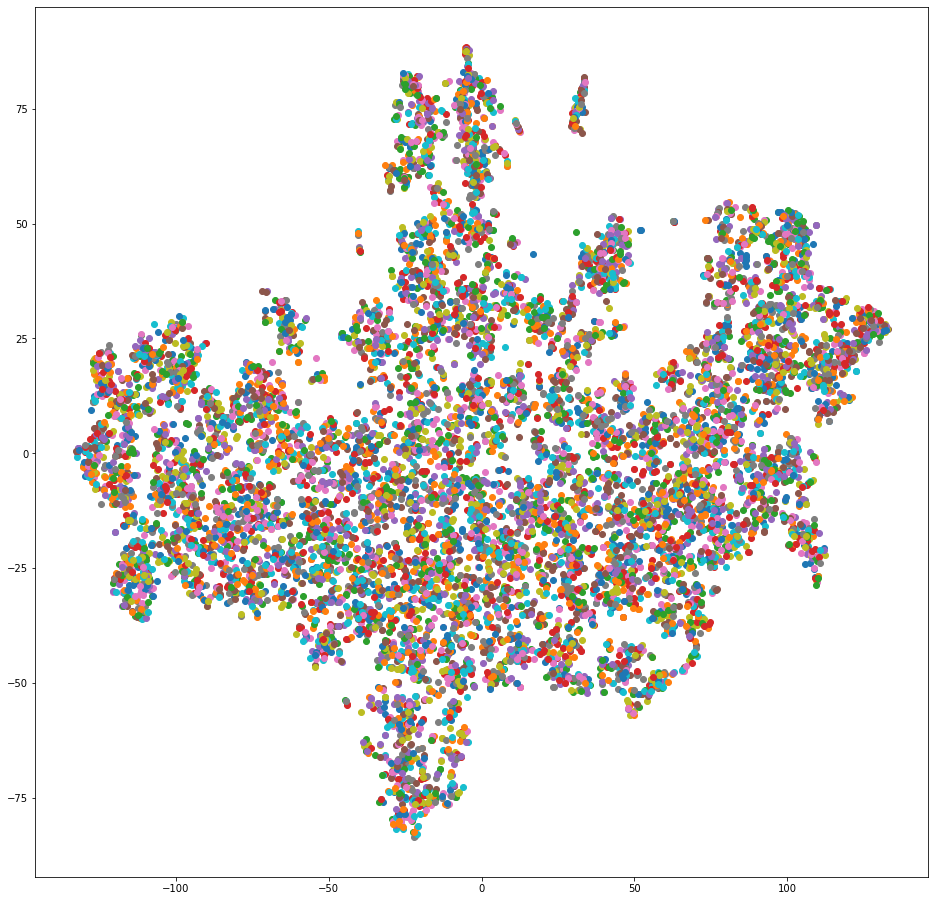

In [16]:
#Word2Vec t-SNE visiualization
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore",category=DeprecationWarning)

def tsne_plot(model):
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        
    plt.show()
tsne_plot(w2v_model)

In [17]:
#Train Doc2Vec models upon vocab_v1
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
warnings.filterwarnings("ignore",category=DeprecationWarning)

tagged_data = [TaggedDocument(doc,[i]) for i, doc in enumerate(docs)]

d2v_model = Doc2Vec(tagged_data, vector_size=50, min_count=2, epochs=40, workers = 8)
d2v_model.wv.most_similar(positive=["president"])

[('dole', 0.7436418533325195),
 ('senator', 0.7298712730407715),
 ('executive', 0.7017545700073242),
 ('clinton', 0.6883397698402405),
 ('stolow', 0.6867389678955078),
 ('hosni', 0.6696591377258301),
 ('sen', 0.6626279354095459),
 ('yeltsin', 0.6592135429382324),
 ('stephanopoulos', 0.6568024158477783),
 ('hhs', 0.6550884246826172)]

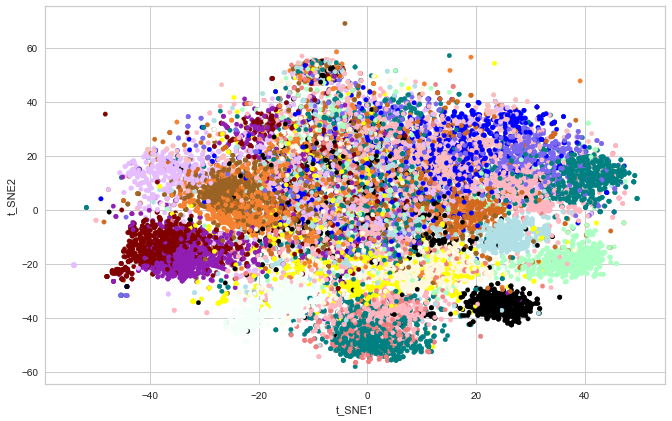

In [19]:
#Doc2Vec t-SNE visiualization
import pandas as pd
from yellowbrick.text import TSNEVisualizer
semantic_labels = dataset.target_names
warnings.filterwarnings("ignore",category=DeprecationWarning)

colormap = ['#FFB6C1', '#FFB6C1','#7B68EE', '#0000FF', '#fabebe', '#008080', '#e6beff', '#9a6324', '#f58231', '#911eb4', '#800000', '#aaffc3', 
           '#D2691E', '#000000', '#B0E0E6', '#008080', '#FFF8DC', '#F5FFFA', '#FFFF00', '#F08080']
color = []
for i in range(0,len(dataset.target)):
    color.append(colormap[dataset.target[i]])
    
tsne = TSNE(n_components = 2, n_jobs=8)
D2v_tsne = tsne.fit_transform(d2v_model.docvecs.vectors_docs[:len(dataset.target)])
df_D2v = pd.DataFrame(D2v_tsne, columns=['t_SNE1','t_SNE2'])

df_D2v.plot.scatter(x = 't_SNE1', y='t_SNE2', c=color)
tsne = TSNEVisualizer(size=(800, 500))

In [ ]:
#transfrom TFIDF corpus into feautre vectors and perform KMeans clustering, but it take forever to run for our machine
from gensim.matutils import corpus2dense
from sklearn.cluster import KMeans

dense_vector = corpus2dense(corpus_tfidf, len(dictionary))
km = KMeans(n_clusters=20)
y = km.fit_predict(dense_vector.T)

In [20]:
# BoW Kmeans train
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=0.5,min_df=0.05,stop_words='english')
cv_fit=cv.fit_transform(dataset.data)
print(cv_fit)


bow_model = KMeans(n_clusters=20)
bow_model.fit(cv_fit)

feature_name = cv.get_feature_names()
print(feature_name)

  (0, 61)	1
  (0, 84)	1
  (0, 27)	1
  (0, 71)	1
  (1, 33)	3
  (1, 28)	1
  (1, 34)	1
  (1, 72)	1
  (1, 11)	2
  (1, 78)	2
  (1, 74)	1
  (1, 53)	2
  (1, 30)	1
  (1, 80)	1
  (1, 64)	1
  (1, 29)	2
  (2, 27)	2
  (2, 33)	1
  (2, 72)	1
  (2, 0)	2
  (2, 57)	2
  (2, 19)	2
  (2, 43)	5
  (2, 3)	4
  (2, 20)	5
  :	:
  (18841, 76)	3
  (18841, 66)	1
  (18841, 59)	1
  (18841, 44)	2
  (18841, 8)	2
  (18842, 19)	1
  (18842, 36)	1
  (18842, 6)	1
  (18843, 57)	2
  (18843, 31)	1
  (18843, 44)	1
  (18844, 61)	1
  (18844, 84)	1
  (18844, 3)	1
  (18844, 76)	1
  (18844, 75)	1
  (18844, 68)	1
  (18844, 7)	2
  (18844, 48)	1
  (18844, 81)	1
  (18844, 82)	1
  (18845, 33)	1
  (18845, 16)	1
  (18845, 82)	1
  (18845, 49)	1
['10', 'able', 'actually', 'available', 'believe', 'best', 'better', 'bit', 'called', 'case', 'com', 'come', 'course', 'day', 'did', 'didn', 'different', 'does', 'doesn', 'don', 'edu', 'end', 'fact', 'far', 'following', 'god', 'going', 'good', 'got', 'great', 'having', 'help', 'information', 'just',

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 2 0 2]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


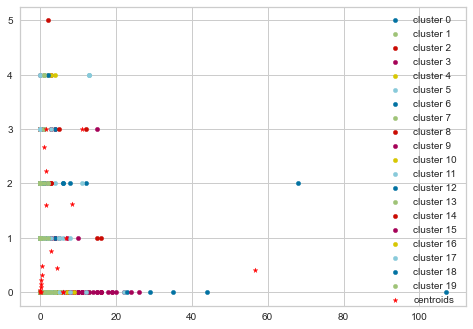

<Figure size 57600x57600 with 0 Axes>

In [21]:
# Plot graph
cv_fit = cv_fit.toarray()
print(cv_fit)
cvpredict = bow_model.fit_predict(cv_fit)

for i in range (0,20):
    plt.scatter(cv_fit[cvpredict == i,0], cv_fit[cvpredict == i,1], s=20,
            marker='o',
            label='cluster ' + str(i))
    
plt.scatter(bow_model.cluster_centers_[:, 0], bow_model.cluster_centers_[:, 1], s=25, marker='*',
        c='red', edgecolor='red',
        label='centroids')
plt.legend(scatterpoints=1)
plt.figure(figsize=(800,800))

plt.show()

In [22]:
#NMI value
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
feature = cv.transform(dataset.data)
model_predict = bow_model.predict(feature)

print('NMI value: ',nmi(dataset.target, model_predict))

NMI value:  0.039841780378890405


In [23]:
# tf_idf Kmeans train
from sklearn.feature_extraction.text import TfidfVectorizer

cv1 = TfidfVectorizer(max_df=0.5,min_df=0.05,stop_words='english')
cv1_fit=cv1.fit_transform(dataset.data)
print(cv1_fit)

tfidf_model = KMeans(n_clusters=20)
tfidf_model.fit(cv1_fit)

  (0, 71)	0.41031431268014185
  (0, 27)	0.44063307578843464
  (0, 84)	0.5476376673536575
  (0, 61)	0.5810143222214845
  (1, 29)	0.41179967952485635
  (1, 64)	0.2086527802732639
  (1, 80)	0.1620493838169988
  (1, 30)	0.2077368211437523
  (1, 53)	0.41763218054928386
  (1, 74)	0.19913367098493223
  (1, 78)	0.3372495851616127
  (1, 11)	0.39193200855400767
  (1, 72)	0.15003096229508595
  (1, 34)	0.13672335062803498
  (1, 28)	0.18905463468438674
  (1, 33)	0.3988826810631739
  (2, 79)	0.058662670168300485
  (2, 77)	0.12588788774340345
  (2, 24)	0.14331813239530325
  (2, 10)	0.2849416279070754
  (2, 36)	0.13535094032521694
  (2, 76)	0.0587081040252005
  (2, 32)	0.5531251675441304
  (2, 46)	0.16952794779050248
  (2, 47)	0.343540737848009
  :	:
  (18841, 44)	0.3316187302394812
  (18841, 59)	0.17929541244004588
  (18841, 66)	0.19066720038991583
  (18841, 76)	0.5219112853791433
  (18841, 0)	0.6098290609563647
  (18842, 6)	0.7063764936952214
  (18842, 36)	0.49271657169111704
  (18842, 19)	0.5081954

KMeans(n_clusters=20)

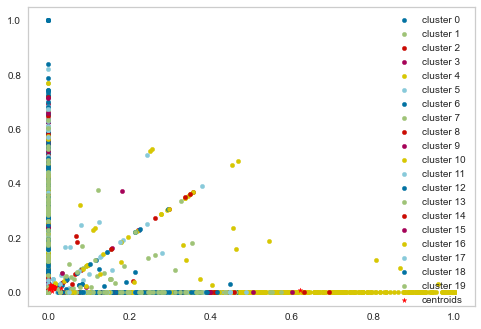

<Figure size 57600x57600 with 0 Axes>

In [24]:
#plot graph
cv1_fit = cv1_fit.toarray()
cv1predict = tfidf_model.fit_predict(cv1_fit)

for i in range (0,20):
    plt.scatter(cv1_fit[cv1predict == i,0], cv1_fit[cv1predict == i,1], s=20,
            marker='o',
            label='cluster ' + str(i))
    
plt.scatter(tfidf_model.cluster_centers_[:, 0], tfidf_model.cluster_centers_[:, 1], s=25, marker='*',
        c='red', edgecolor='red',
        label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.figure(figsize=(800,800))

plt.show()

In [26]:
#NMI value
feature1 = cv1.transform(dataset.data)
model_predict1 = tfidf_model.predict(feature1)

print('NMI value: ',nmi(dataset.target, model_predict1))

NMI value:  0.07989125100854619


  (0, 71)	0.41031431268014185
  (0, 27)	0.44063307578843464
  (0, 84)	0.5476376673536575
  (0, 61)	0.5810143222214845
  (1, 29)	0.41179967952485635
  (1, 64)	0.2086527802732639
  (1, 80)	0.1620493838169988
  (1, 30)	0.2077368211437523
  (1, 53)	0.41763218054928386
  (1, 74)	0.19913367098493223
  (1, 78)	0.3372495851616127
  (1, 11)	0.39193200855400767
  (1, 72)	0.15003096229508595
  (1, 34)	0.13672335062803498
  (1, 28)	0.18905463468438674
  (1, 33)	0.3988826810631739
  (2, 79)	0.058662670168300485
  (2, 77)	0.12588788774340345
  (2, 24)	0.14331813239530325
  (2, 10)	0.2849416279070754
  (2, 36)	0.13535094032521694
  (2, 76)	0.0587081040252005
  (2, 32)	0.5531251675441304
  (2, 46)	0.16952794779050248
  (2, 47)	0.343540737848009
  :	:
  (18841, 44)	0.3316187302394812
  (18841, 59)	0.17929541244004588
  (18841, 66)	0.19066720038991583
  (18841, 76)	0.5219112853791433
  (18841, 0)	0.6098290609563647
  (18842, 6)	0.7063764936952214
  (18842, 36)	0.49271657169111704
  (18842, 19)	0.5081954

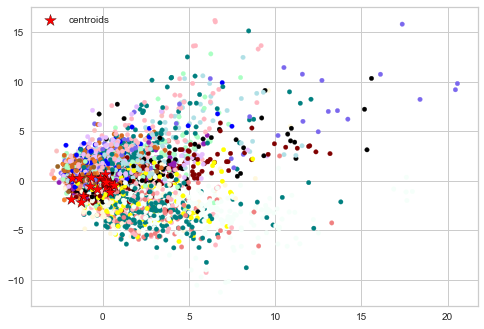

In [27]:
#Doc2vec Kmeans train
from sklearn.decomposition import PCA

cv2 = TfidfVectorizer(max_df=0.5,min_df=0.05,stop_words='english')
cv2_fit=cv2.fit_transform(dataset.data)
print(cv2_fit)

doc2vecs_model = KMeans(n_clusters=20)

F = doc2vecs_model.fit(d2v_model.docvecs.vectors_docs)

cv3predict = doc2vecs_model.fit_predict(d2v_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
d2v_data = pca.transform(d2v_model.docvecs.vectors_docs)

colormap = ['#FFB6C1', '#FFB6C1','#7B68EE', '#0000FF', '#fabebe', '#008080', '#e6beff', '#9a6324', '#f58231', '#911eb4', '#800000', '#aaffc3', 
           '#D2691E', '#000000', '#B0E0E6', '#008080', '#FFF8DC', '#F5FFFA', '#FFFF00', '#F08080']
color = []
for i in range(0,len(d2v_data)):
    color.append(colormap[dataset.target[i]])
    
plt.figure
plt.scatter(d2v_data[:, 0], d2v_data[:, 1],marker='o', s=20,c=color)
plt.scatter(
        doc2vecs_model.cluster_centers_[:, 0], doc2vecs_model.cluster_centers_[:, 1],
        s=150, marker='*',
        c='red', edgecolor='black',
        label='centroids'
        )
plt.legend(scatterpoints=1)
plt.show()

d2v_target = dataset.target

In [28]:
#NMI value
print('NMI value: ',nmi(d2v_target,cv3predict))

NMI value:  0.2856508602622701


In [ ]:
#Topic distribution Kmeans train
lda_model = KMeans(n_clusters=20)

dist = lda_temp[:,:,1]
T = lda_model.fit(dist)

pca = PCA(n_components=2).fit(dist)
lda_data = pca.transform(dist)


colormap = ['#FFB6C1', '#FFB6C1','#7B68EE', '#0000FF', '#fabebe', '#008080', '#e6beff', '#9a6324', '#f58231', '#911eb4', '#800000', '#aaffc3', 
           '#D2691E', '#000000', '#B0E0E6', '#008080', '#F5FFFA', '#F5FFFA', '#FFFF00', '#F08080']
color = []
for i in range(0,len(lda_data)):
    color.append(colormap[dataset.target[i]])

plt.figure
plt.scatter(lda_data[:, 0], lda_data[:, 1], marker='o', s=20,c=colors)

plt.scatter(
        lda_model.cluster_centers_[:, 0], lda_model.cluster_centers_[:, 1],
        s=150, marker='*',
        c='red', edgecolor='black',
        label='centroids'
        )
plt.legend(scatterpoints=1)
plt.show()

In [30]:
#step 6: test different preprocessing ways and compare LDA visualization
def pre_processing(docs):
    tokenizer = RegexpTokenizer(r"\w+(?:[-'+]\w+)*|\w+")
    en_stop = get_stop_words('en')
    for doc in docs:
        raw_text = doc.lower()
        tokens_text = tokenizer.tokenize(raw_text)
        stopped_tokens_text = [i for i in tokens_text if not i in en_stop]
        doc = [token for token in stopped_tokens_text if not token.isnumeric()]
        doc = [token for token in stopped_tokens_text if len(token) > 1]
        # you could always add some new preprocessing here
        yield doc
docs_v2 = list(pre_processing(corpus))

dictionary_v2 = corpora.Dictionary(docs_v2)
dictionary_v2.filter_extremes(no_below=5, no_above=0.5)
BoW_corpus_v2 = [dictionary_v2.doc2bow(doc) for doc in docs]    



tfidf = TfidfModel(BoW_corpus_v2)
corpus_tfidf_v2 = tfidf[BoW_corpus_v2]  #???

lda = LdaModel(corpus=BoW_corpus_v2, id2word=dictionary_v2, num_topics=20)
vis_data = gensimvis.prepare(lda, BoW_corpus_v2, dictionary_v2)
pyLDAvis.display(vis_data)

In [31]:
lda = LdaModel(corpus=BoW_corpus_v2, id2word=dictionary_v2, num_topics=6)
vis_data = gensimvis.prepare(lda, BoW_corpus_v2, dictionary_v2)
pyLDAvis.display(vis_data)

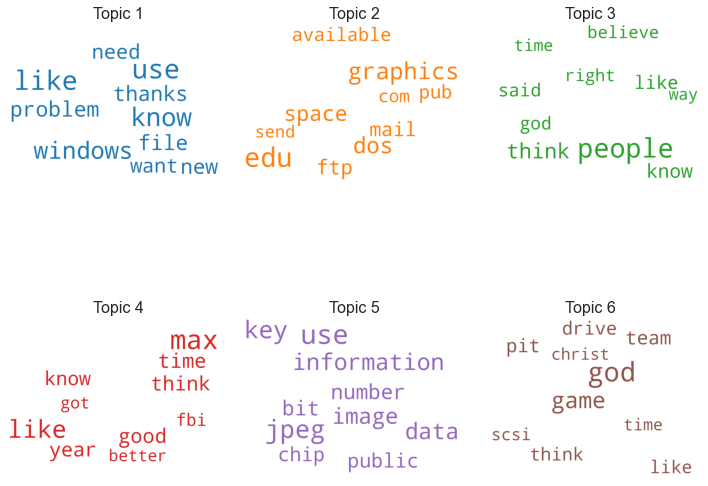

In [32]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

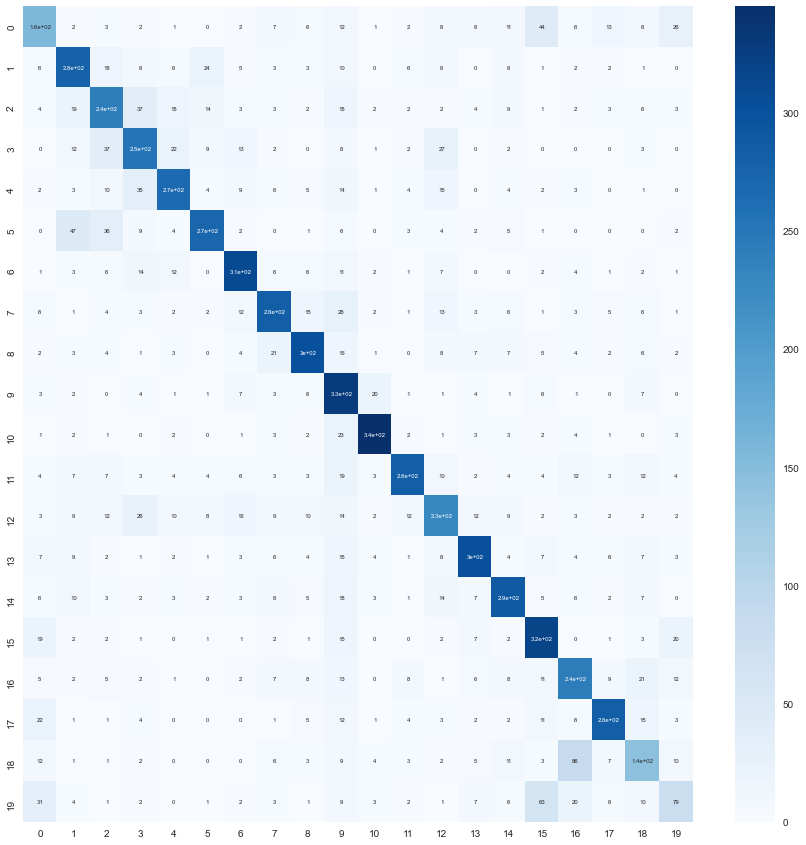

                          precision    recall  f1-score   support

             alt.atheism       0.54      0.49      0.51       319
           comp.graphics       0.67      0.71      0.69       389
 comp.os.ms-windows.misc       0.61      0.61      0.61       394
comp.sys.ibm.pc.hardware       0.62      0.65      0.63       392
   comp.sys.mac.hardware       0.75      0.69      0.72       385
          comp.windows.x       0.79      0.69      0.74       395
            misc.forsale       0.77      0.80      0.79       390
               rec.autos       0.74      0.71      0.73       396
         rec.motorcycles       0.78      0.76      0.77       398
      rec.sport.baseball       0.55      0.83      0.66       397
        rec.sport.hockey       0.87      0.86      0.87       399
               sci.crypt       0.84      0.71      0.77       396
         sci.electronics       0.63      0.59      0.61       393
                 sci.med       0.79      0.76      0.78       396
         

In [33]:
#SVMs classification
from sklearn.svm import LinearSVC
from sklearn import metrics
import seaborn as sns

training_dataset = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'), shuffle=True)
testing_dataset = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'), shuffle=True)

svm_cv = TfidfVectorizer()
cv_ft = svm_cv.fit_transform(training_dataset.data)#Traning data
cv_t = svm_cv.transform(testing_dataset.data)#Test data
X_train = cv_ft
Y_train = training_dataset.target

X_test = cv_t
Y_test = testing_dataset.target
svm_model = LinearSVC()

svm_model.fit(X_train, Y_train)
svm_predict = svm_model.predict(X_test)
svm_predict_score = svm_model.decision_function(X_test)

fig,ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(metrics.confusion_matrix(Y_test,svm_predict), annot=True, cmap='Blues',annot_kws={"size":6})
plt.show()

print(metrics.classification_report(Y_test, svm_predict, target_names=testing_dataset.target_names))
print('nmi: ',nmi(Y_test,svm_predict))
print('accuracy: ',metrics.accuracy_score(Y_test,svm_predict))
print("Precision:",metrics.precision_score(Y_test, svm_predict,average='weighted'))
print("Recall:",metrics.recall_score(Y_test, svm_predict,average='weighted'))

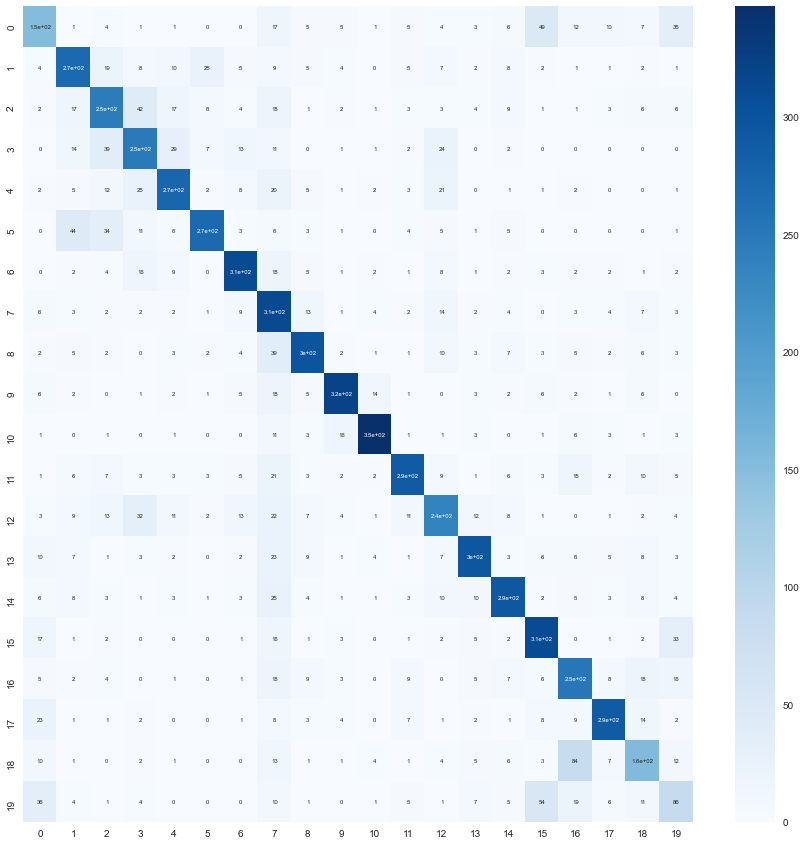

                          precision    recall  f1-score   support

             alt.atheism       0.53      0.48      0.50       319
           comp.graphics       0.67      0.70      0.68       389
 comp.os.ms-windows.misc       0.62      0.62      0.62       394
comp.sys.ibm.pc.hardware       0.62      0.64      0.63       392
   comp.sys.mac.hardware       0.73      0.71      0.72       385
          comp.windows.x       0.84      0.69      0.75       395
            misc.forsale       0.80      0.80      0.80       390
               rec.autos       0.49      0.79      0.61       396
         rec.motorcycles       0.78      0.75      0.77       398
      rec.sport.baseball       0.86      0.81      0.83       397
        rec.sport.hockey       0.90      0.87      0.88       399
               sci.crypt       0.81      0.73      0.77       396
         sci.electronics       0.64      0.60      0.62       393
                 sci.med       0.81      0.74      0.78       396
         

In [36]:
#Bonus: RNNs classification
from sklearn.neural_network import MLPClassifier

training_dataset = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'), shuffle=True)
testing_dataset = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'), shuffle=True)

mlp_cv = TfidfVectorizer()
cv_ft = mlp_cv.fit_transform(training_dataset.data)#Traning data
cv_t = mlp_cv.transform(testing_dataset.data)#Test data

X_train = cv_ft
Y_train = training_dataset.target

X_test = cv_t
Y_test = testing_dataset.target

mlp_model = MLPClassifier()
mlp_model.fit(X_train, Y_train)
mlp_predict = mlp_model.predict(X_test)

fig,ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(metrics.confusion_matrix(Y_test,mlp_predict), annot=True, cmap='Blues',annot_kws={"size":6})
plt.show()

print(metrics.classification_report(Y_test, mlp_predict, target_names=testing_dataset.target_names))
print('nmi: ',nmi(Y_test,mlp_predict))
print('accuracy: ',metrics.accuracy_score(Y_test,mlp_predict))
print("Recall:",metrics.recall_score(Y_test, mlp_predict,average='weighted'))

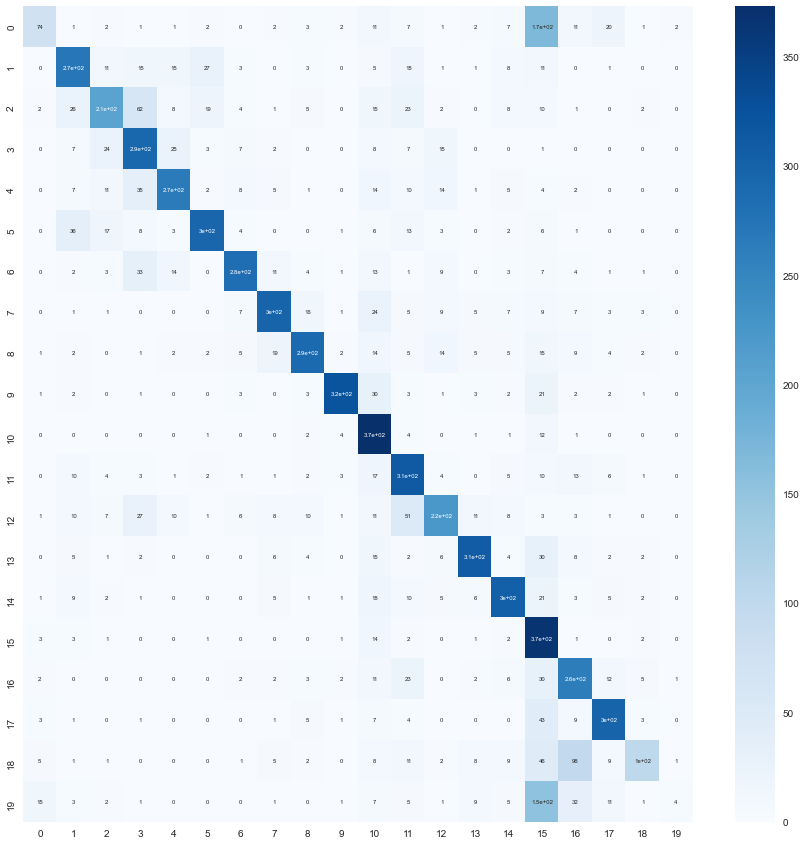

                          precision    recall  f1-score   support

             alt.atheism       0.69      0.23      0.35       319
           comp.graphics       0.68      0.69      0.69       389
 comp.os.ms-windows.misc       0.70      0.52      0.60       394
comp.sys.ibm.pc.hardware       0.61      0.75      0.67       392
   comp.sys.mac.hardware       0.77      0.69      0.73       385
          comp.windows.x       0.83      0.75      0.79       395
            misc.forsale       0.85      0.73      0.78       390
               rec.autos       0.81      0.75      0.78       396
         rec.motorcycles       0.82      0.73      0.77       398
      rec.sport.baseball       0.94      0.81      0.87       397
        rec.sport.hockey       0.60      0.93      0.73       399
               sci.crypt       0.61      0.79      0.69       396
         sci.electronics       0.72      0.57      0.64       393
                 sci.med       0.85      0.78      0.81       396
         

In [37]:
#Bonus: Naive Bayes classification
from sklearn.naive_bayes import MultinomialNB

training_dataset = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'), shuffle=True)
testing_dataset = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'), shuffle=True)

nv_cv = TfidfVectorizer()
cv_ft = nv_cv.fit_transform(training_dataset.data)#Traning data
cv_t = nv_cv.transform(testing_dataset.data)#Test data

X_train = cv_ft
Y_train = training_dataset.target

X_test = cv_t
Y_test = testing_dataset.target

nv_model = MultinomialNB(alpha=0.1)
nv_model.fit(X_train, Y_train)
nv_predict = nv_model.predict(X_test)
nv_predict_score = nv_model.predict_proba(X_test)

fig,ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(metrics.confusion_matrix(Y_test,nv_predict), annot=True, cmap='Blues',annot_kws={"size":6})
plt.show()

print(metrics.classification_report(Y_test, nv_predict, target_names=testing_dataset.target_names))
print('nmi: ',nmi(Y_test,nv_predict))
print('accuracy: ',metrics.accuracy_score(Y_test,nv_predict))
print("Precision:",metrics.precision_score(Y_test, nv_predict,average='weighted'))
print("Recall:",metrics.recall_score(Y_test, nv_predict,average='weighted'))